In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import zipfile
import json
from PIL import Image
from tqdm import tqdm
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

#미션 1-2
import io
import cv2
from torchvision import models, transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import albumentations as A #설치 필요
from albumentations.pytorch import ToTensorV2
import torchmetrics # 설치 필요
from torch.optim.lr_scheduler import StepLR

## 미션 3-1
from sklearn.metrics import pairwise_distances
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
pd.options.mode.chained_assignment = None

## 미션 3-2
from sklearn.metrics.pairwise import cosine_similarity
from io import BytesIO
import optuna # 설치 필요

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **미션2 : 라벨 데이터를 통한 패션 스타일 선호 여부 파악**
---

## **미션 2-1**
- 주어진 라벨링 데이터의 파일 명은 아래와 같은 형식이다.
- “{W/T}_{이미지ID}_{시대별}_{스타일별}_{성별}_{설문ID}.json”
- 이에 기반하여 “설문ID” 수 기준으로 “성별&스타일”통계치를 아래표 형식으로 기입한다.

In [ ]:
# 유효한 라벨링 데이터 추출을 위한 이미지 데이터 이름 리스트 정리 :  이미지 데이터에 있는 이미지ID만을 식별

# zip 파일에서 이미지 데이터 리스트 담기
with zipfile.ZipFile('/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip','r') as zip_file:
    file_list = zip_file.namelist()

    train_file_list = [file for file in file_list if file.startswith('training_image/') and file.endswith('.jpg')]
    valid_file_list = [file for file in file_list if file.startswith('validation_image/') and file.endswith('.jpg')]

# 이미지 id만 추출하기
train_id = [id.split('/')[1][2:7] for id in train_file_list]
unique_train_id = list(set(train_id))
valid_id = [id.split('/')[1][2:7] for id in valid_file_list]
unique_valid_id = list(set(valid_id))

print('훈련 데이터의 이미지ID 개수 :', len(unique_train_id))
print('테스트 데이터의 이미지ID 개수 :', len(unique_valid_id))

훈련 데이터의 이미지ID 개수 : 4066
테스트 데이터의 이미지ID 개수 : 951


In [ ]:
# 이미지id로 유효한 이미지만 필터링하지 않았을 때의 라벨링 데이터 규모

# 경로 설정
zip_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

# 파일 리스트 초기화
train_file_list = []
valid_file_list = []

# 압축 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # 압축 파일 내의 모든 파일 리스트 가져오기
    for file_name in zip_file.namelist():
        # training_label 경로의 JSON 파일을 train_file_list에 추가
        if file_name.startswith('training_label/') and file_name.endswith('.json') :
            train_file_list.append(file_name)
        # validation_label 경로의 JSON 파일을 valid_file_list에 추가
        elif file_name.startswith('validation_label/') and file_name.endswith('.json') :
            valid_file_list.append(file_name)

# 결과 확인
print(f"Training 라벨링 데이터 개수: {len(train_file_list)}")
print(f"Validation 라벨링 데이터 개수: {len(valid_file_list)}")

Training 라벨링 데이터 개수: 211346
Validation 라벨링 데이터 개수: 36383


### **1) 유효한 데이터만을 필터링**

In [ ]:
# 필터링 했을 때의 개수와 하지 않았을 때의 개수 비교

# 경로 설정
zip_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

# 파일 리스트 초기화
train_file_list = []
valid_file_list = []

# 압축 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # 압축 파일 내의 모든 파일 리스트 가져오기
    for file_name in zip_file.namelist():
        # training_label 경로의 JSON 파일을 train_file_list에 추가
        if file_name.startswith('training_label/') and file_name.endswith('.json') and file_name.split('/')[1][2:7] in unique_train_id :
            train_file_list.append(file_name)
        # validation_label 경로의 JSON 파일을 valid_file_list에 추가
        elif file_name.startswith('validation_label/') and file_name.endswith('.json') and file_name.split('/')[1][2:7] in unique_valid_id :
            valid_file_list.append(file_name)

# 결과 확인
print(f"필터링 이후의 Training 라벨링 데이터 개수: {len(train_file_list)}")
print(f"필터링 이후의 Validation 라벨링 데이터 개수: {len(valid_file_list)}")

필터링 이후의 Training 라벨링 데이터 개수: 20304
필터링 이후의 Validation 라벨링 데이터 개수: 4263


### **2) 카테고리별 분류**

In [ ]:
# 1-1 미션과 동일하게 파일 구분

# train/valid 데이터 중 여성 데이터
w_train_file_list = [file for file in train_file_list if file[-13:-12] == 'W']
w_valid_file_list = [file for file in valid_file_list if file[-13:-12] == 'W']

# train/valid 데이터 중 남성 데이터
m_train_file_list = [file for file in train_file_list if file[-13:-12] == 'M']
m_valid_file_list = [file for file in valid_file_list if file[-13:-12] == 'M']

# 각 파일명의 "성별-스타일"만 추출
w_train_file_name = [file[26:][:-14] for file in w_train_file_list]
w_valid_file_name = [file[28:][:-14] for file in w_valid_file_list]

m_train_file_name = [file[26:][:-14] for file in m_train_file_list]
m_valid_file_name = [file[28:][:-14] for file in m_valid_file_list]

### **3) 훈련 데이터의 통계치 산출**

In [ ]:
# 훈련 데이터 통계치 정리

# 여성 훈련 데이터 통계
w_train_temp = pd.DataFrame(pd.Series(w_train_file_name).value_counts())
w_train = w_train_temp.reset_index().rename(columns={'index':'style'})
w_train['sex'] = 'female'

# 남성 훈련 데이터 통계
m_train_temp = pd.DataFrame(pd.Series(m_train_file_name).value_counts())
m_train = m_train_temp.reset_index().rename(columns={'index':'style'})
m_train['sex'] = 'male'

# 훈련 데이터 통계
train_label = pd.concat([w_train,m_train],axis=0)
train_label

,style,count,sex
0,sportivecasual,1143,female
1,minimal,780,female
2,feminine,762,female
3,normcore,646,female
4,powersuit,623,female
5,classic,504,female
6,bodyconscious,500,female
7,athleisure,424,female
8,kitsch,374,female
9,oriental,369,female


4) 검증 데이터의 통계치 산출

In [ ]:
# 검증 데이터 통계치 정리

# 여성 검증 데이터 통계
w_valid_temp = pd.DataFrame(pd.Series(w_valid_file_name).value_counts())
w_valid = w_valid_temp.reset_index().rename(columns={'index':'style'})
w_valid['sex'] = 'female'

# 남성 검증 데이터 통계
m_valid_temp = pd.DataFrame(pd.Series(m_valid_file_name).value_counts())
m_valid = m_valid_temp.reset_index().rename(columns={'index':'style'})
m_valid['sex'] = 'male'

# concat하여 여성 데이터와 남성 데이터 병합
valid_label = pd.concat([w_valid,m_valid],axis=0)
valid_label

,style,count,sex
0,sportivecasual,278,female
1,feminine,208,female
2,minimal,171,female
3,powersuit,160,female
4,classic,117,female
5,bodyconscious,114,female
6,athleisure,80,female
7,space,75,female
8,oriental,71,female
9,ecology,70,female


## **미션 2-2**
- 2-1에서 구한 유효한 라벨링 데이터만 따로 분리하여 100명 응답자의 “스타일 선호 정보표”를 구한다.

### **1) 라벨링 데이터 로드**

In [ ]:
# 압축 파일 경로 설정
zip_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

# JSON 데이터를 담을 리스트 초기화
json_data_list_train = []

# 압축 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # 압축 파일 내의 모든 파일 리스트 가져오기
    for file_name in zip_file.namelist():
        # 'training_label/' 경로에 있는 JSON 파일만 선택
        if file_name.startswith('training_label/') and file_name.endswith('.json') and file_name.split('/')[1][2:7] in unique_train_id :
            # JSON 파일 읽기
            with zip_file.open(file_name) as json_file:
                # JSON 데이터를 파싱하여 딕셔너리로 변환
                data = json.load(json_file)
                json_data_list_train.append(data)
# 결과 출력
print(f"훈련 데이터로부터 총 {len(json_data_list_train)}개의 라벨링 데이터를 불러왔으며")

# 고유한 id를 담는 리스트 초기화
id_list_train = []

# 고유한 id의 개수 세기
for i in range(0, len(json_data_list_train)) :
    id = json_data_list_train[i]['user']['R_id'] # 라벨링 데이터 중 응답자의 id
    id_list_train.append(id) # 리스트에 추가
id_list_train = list(set(id_list_train)) # 중복 제거 후 유니크한 ID의 개수를 구함
print("고유한 id 개수는", len(id_list_train), "개입니다.") # 결과 출력

훈련 데이터로부터 총 20304개의 라벨링 데이터를 불러왔으며
고유한 id 개수는 4009 개입니다.


In [ ]:
# train_label의 id를 담는 리스트 초기화
id_all_train = []

# train_label 데이터에서 id별 응답 수 개수 세기
for i in range(0, len(json_data_list_train)):
    id = json_data_list_train[i]['user']['R_id'] # train 라벨링 데이터 중 응답자의 id
    id_all_train.append(id) # 리스트에 추가
id_df_train = pd.DataFrame({'id' : id_all_train}) # 데이터 프레임으로 변환
id_df_train = id_df_train.value_counts().reset_index(name='count') # 빈도 수 계산
id_df_train

,id,count
0,63508,49
1,60173,49
2,64336,48
3,63927,48
4,59637,48
...,...,...
4004,64939,1
4005,64938,1
4006,64928,1
4007,64921,1


In [ ]:
# JSON 데이터를 담을 리스트 초기화 _valid
json_data_list_valid = []

# 압축 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # 압축 파일 내의 모든 파일 리스트 가져오기
    for file_name in zip_file.namelist():
        # 'training_label/' 경로에 있는 JSON 파일만 선택
        if file_name.startswith('validation_label/') and file_name.endswith('.json') and file_name.split('/')[1][2:7] in unique_valid_id :
            # JSON 파일 읽기
            with zip_file.open(file_name) as json_file:
                # JSON 데이터를 파싱하여 딕셔너리로 변환
                data = json.load(json_file)
                json_data_list_valid.append(data)

# valid_label 데이터에서 id별 응답 수 개수 세기
id_all_valid = []
for i in range(0, len(json_data_list_valid)):
    id = json_data_list_valid[i]['user']['R_id']
    id_all_valid.append(id)
id_df_valid = pd.DataFrame({'id' : id_all_valid})
id_df_valid = id_df_valid.value_counts().reset_index(name='count')
id_df_valid

,id,count
0,63481,17
1,59642,16
2,63934,15
3,64747,15
4,65071,15
...,...,...
1983,26425,1
1984,63528,1
1985,63525,1
1986,26539,1


### **2) 응답 수가 많은 상위 100명의 응답자의 id와 응답 수 계산**

In [ ]:
# id_df_train와 id_df_valid id를 기준으로 결합
id_counts = id_df_train.merge(id_df_valid, on='id', how='outer')

# id별로 train/valid의 응답 합계 계산
id_counts['count'] = id_counts['count_x'].fillna(0) + id_counts['count_y'].fillna(0)

# 합계 컬럼만 남기고 응답 수 상위 100명의 id만 남겨 내림차순 정렬
id_counts = id_counts.drop(columns=['count_x', 'count_y']).sort_values(by='count', ascending=False).nlargest(100, 'count')
id_counts

,id,count
2709,64747,60.0
2614,64561,58.0
2034,63405,58.0
2921,65139,58.0
2528,64346,58.0
...,...,...
2636,64598,55.0
1955,63156,55.0
774,28571,55.0
1988,63316,55.0


### **3) 각 id별로 선호도 여부 구하기**

In [ ]:
# 압축 파일 경로 설정
zip_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

# JSON 데이터를 담을 리스트 초기화
json_data_list = []

# 압축 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # 압축 파일 내의 모든 파일 리스트 가져오기
    for file_name in zip_file.namelist():
        # 'training_label/' 경로에 있는 JSON 파일만 선택
        if file_name.startswith('training_label/') and file_name.endswith('.json') and file_name.split('/')[1][2:7] in unique_train_id :
            # JSON 파일 읽기
            with zip_file.open(file_name) as json_file:
                # JSON 데이터를 파싱하여 딕셔너리로 변환
                data = json.load(json_file)
                json_data_list.append(data)

# 상위 100명의 ID 리스트
id_list = id_counts['id'].tolist()

# train 데이터의 선호와 비선호 분류
dict1 = {} # 딕셔너리 초기화
for id in id_list:
  list_good = [] # 선호한다고 응답한 파일의 리스트
  list_bad = [] # 비선호한다고 응답한 파일의 리스트
  for i in range(0, len(json_data_list)):
    if json_data_list[i]['user']['R_id'] == id :
      if json_data_list[i]['item']['survey']['Q5'] ==2: # 선호한다고 응답한 파일 리스트에 담기
        list_good.append(json_data_list[i]['item']['imgName'])
      elif json_data_list[i]['item']['survey']['Q5'] ==1: # 비선호한다고 응답한 파일 리스트에 담기
        list_bad.append(json_data_list[i]['item']['imgName'])
  dict1[id] = [list_good,list_bad] # 닥셔너리 형태로 보관

# 딕셔너리의 key를 인덱스, value를 컬럼으로 변환
data = {
    'list_good': [value[0] for value in dict1.values()],  # list_good 값
    'list_bad': [value[1] for value in dict1.values()]    # list_bad 값
}

# 데이터프레임 생성 (index는 dict1의 key 사용)
df_train = pd.DataFrame(data, index=dict1.keys())

# 결과 출력
df_train.columns = ['스타일 선호', '스타일 비선호']
df_train


,스타일 선호,스타일 비선호
64747,"[W_03194_50_classic_W.jpg, W_30434_60_minimal_...","[W_02247_50_classic_W.jpg, W_02498_50_feminine..."
64561,"[W_18066_50_classic_W.jpg, W_18205_50_feminine...","[W_08584_50_feminine_W.jpg, W_12032_50_feminin..."
63405,"[W_00555_50_ivy_M.jpg, W_04522_50_ivy_M.jpg, W...","[W_12904_50_ivy_M.jpg, W_15472_70_hippie_M.jpg..."
65139,"[W_06684_60_mods_M.jpg, W_15891_80_bold_M.jpg,...","[W_06259_50_ivy_M.jpg, W_50824_50_ivy_M.jpg, W..."
64346,"[W_09154_50_ivy_M.jpg, W_23922_50_ivy_M.jpg, W...","[W_02678_50_ivy_M.jpg, W_24931_50_ivy_M.jpg, W..."
...,...,...
64598,"[W_02024_50_classic_W.jpg, W_04895_50_classic_...","[W_02442_50_feminine_W.jpg, W_18079_50_classic..."
63156,"[W_03152_50_feminine_W.jpg, W_18526_50_feminin...","[W_05271_50_feminine_W.jpg, W_10518_50_feminin..."
28571,"[W_00073_50_ivy_M.jpg, W_12826_50_ivy_M.jpg, W...","[W_06735_50_ivy_M.jpg, W_06735_50_ivy_M.jpg, W..."
63316,"[W_07586_60_minimal_W.jpg, W_13531_60_minimal_...","[W_00130_50_feminine_W.jpg, W_09524_50_classic..."


### **4) 똑같은 절차로 검증 데이터의 스타일 선호 정보표 구하기**

In [ ]:
# 압축 파일 경로 설정
zip_path = '/content/drive/MyDrive/2024 데이터 크리에이터 캠프 대학부 데이터셋.zip'

# JSON 데이터를 담을 리스트 초기화
json_data_list = []

# 압축 파일 열기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # 압축 파일 내의 모든 파일 리스트 가져오기
    for file_name in zip_file.namelist():
        # 'training_label/' 경로에 있는 JSON 파일만 선택
        if file_name.startswith('validation_label/') and file_name.endswith('.json') and file_name.split('/')[1][2:7] in unique_valid_id :
            # JSON 파일 읽기
            with zip_file.open(file_name) as json_file:
                # JSON 데이터를 파싱하여 딕셔너리로 변환
                data = json.load(json_file)
                json_data_list.append(data)

# 상위 100명의 ID 리스트
id_list = id_counts['id'].tolist()

# valid 데이터의 선호와 비선호 분류
dict1 = {} # 딕셔너리 초기화
for id in id_list:
  list_good = [] # 선호한다고 응답한 파일의 리스트
  list_bad = [] # 비선호한다고 응답한 파일의 리스트
  for i in range(0, len(json_data_list)):
    if json_data_list[i]['user']['R_id'] == id :
      if json_data_list[i]['item']['survey']['Q5'] ==2: # 선호한다고 응답한 파일 리스트에 담기
        list_good.append(json_data_list[i]['item']['imgName'])
      elif json_data_list[i]['item']['survey']['Q5'] ==1: # 비선호한다고 응답한 파일 리스트에 담기
        list_bad.append(json_data_list[i]['item']['imgName'])
  dict1[id] = [list_good,list_bad]

# 딕셔너리의 key를 인덱스, value를 컬럼으로 변환
data = {
    'list_good': [value[0] for value in dict1.values()],  # list_good 값
    'list_bad': [value[1] for value in dict1.values()]    # list_bad 값
}

# 데이터프레임 생성 (index는 dict1의 key 사용)
df_valid = pd.DataFrame(data, index=dict1.keys())

# 결과 출력
df_valid.columns = ['스타일 선호', '스타일 비선호']
df_valid

,스타일 선호,스타일 비선호
64747,"[W_20598_70_military_W.jpg, W_37491_70_militar...","[W_02498_50_feminine_W.jpg, W_14102_50_feminin..."
64561,"[W_18205_50_feminine_W.jpg, W_22239_60_space_W...","[W_23519_60_minimal_W.jpg, W_48457_60_minimal_..."
63405,"[W_01853_60_mods_M.jpg, W_02677_60_mods_M.jpg,...","[W_07187_70_hippie_M.jpg, W_16501_70_hippie_M...."
65139,[W_63644_10_sportivecasual_M.jpg],"[W_24717_60_mods_M.jpg, W_27138_60_mods_M.jpg,..."
64346,"[W_29990_90_hiphop_M.jpg, W_07316_00_metrosexu...","[W_00496_60_mods_M.jpg, W_24838_70_hippie_M.jp..."
...,...,...
64598,"[W_30431_80_powersuit_W.jpg, W_45386_00_orient...","[W_19335_50_feminine_W.jpg, W_20593_70_punk_W...."
63156,"[W_10429_60_minimal_W.jpg, W_14796_60_minimal_...","[W_05271_50_feminine_W.jpg, W_08673_90_kitsch_..."
28571,[W_00073_50_ivy_M.jpg],"[W_15910_60_mods_M.jpg, W_16247_70_hippie_M.jp..."
63316,"[W_05580_10_sportivecasual_W.jpg, W_05791_10_s...","[W_02392_50_feminine_W.jpg, W_19945_70_hippie_..."


### **5) 데이터 결합하여 id별 선호 이미지(훈련/검증)표 구성**

In [ ]:
# 훈련 데이터 결과와 검증 데이터 결과 결합
df_prefer = df_train.merge(df_valid, left_index=True, right_index=True)
df_prefer.index.name = 'id' # 인덱스는 id로 지정
df_prefer

,스타일 선호_x,스타일 비선호_x,스타일 선호_y,스타일 비선호_y
id,,,,
64747,"[W_03194_50_classic_W.jpg, W_30434_60_minimal_...","[W_02247_50_classic_W.jpg, W_02498_50_feminine...","[W_20598_70_military_W.jpg, W_37491_70_militar...","[W_02498_50_feminine_W.jpg, W_14102_50_feminin..."
64561,"[W_18066_50_classic_W.jpg, W_18205_50_feminine...","[W_08584_50_feminine_W.jpg, W_12032_50_feminin...","[W_18205_50_feminine_W.jpg, W_22239_60_space_W...","[W_23519_60_minimal_W.jpg, W_48457_60_minimal_..."
63405,"[W_00555_50_ivy_M.jpg, W_04522_50_ivy_M.jpg, W...","[W_12904_50_ivy_M.jpg, W_15472_70_hippie_M.jpg...","[W_01853_60_mods_M.jpg, W_02677_60_mods_M.jpg,...","[W_07187_70_hippie_M.jpg, W_16501_70_hippie_M...."
65139,"[W_06684_60_mods_M.jpg, W_15891_80_bold_M.jpg,...","[W_06259_50_ivy_M.jpg, W_50824_50_ivy_M.jpg, W...",[W_63644_10_sportivecasual_M.jpg],"[W_24717_60_mods_M.jpg, W_27138_60_mods_M.jpg,..."
64346,"[W_09154_50_ivy_M.jpg, W_23922_50_ivy_M.jpg, W...","[W_02678_50_ivy_M.jpg, W_24931_50_ivy_M.jpg, W...","[W_29990_90_hiphop_M.jpg, W_07316_00_metrosexu...","[W_00496_60_mods_M.jpg, W_24838_70_hippie_M.jp..."
...,...,...,...,...
64598,"[W_02024_50_classic_W.jpg, W_04895_50_classic_...","[W_02442_50_feminine_W.jpg, W_18079_50_classic...","[W_30431_80_powersuit_W.jpg, W_45386_00_orient...","[W_19335_50_feminine_W.jpg, W_20593_70_punk_W...."
63156,"[W_03152_50_feminine_W.jpg, W_18526_50_feminin...","[W_05271_50_feminine_W.jpg, W_10518_50_feminin...","[W_10429_60_minimal_W.jpg, W_14796_60_minimal_...","[W_05271_50_feminine_W.jpg, W_08673_90_kitsch_..."
28571,"[W_00073_50_ivy_M.jpg, W_12826_50_ivy_M.jpg, W...","[W_06735_50_ivy_M.jpg, W_06735_50_ivy_M.jpg, W...",[W_00073_50_ivy_M.jpg],"[W_15910_60_mods_M.jpg, W_16247_70_hippie_M.jp..."


### **6) 미션에서 요구하는 형태로 데이터프레임 변환**

In [ ]:
# 문제에 요구하는 형태를 만족하도록 데이터프레임 생성
df_id_style = pd.DataFrame({'id' : [], '스타일 선호_x' : [], '스타일 비선호_x' : [],
                            '스타일 선호_y' : [], '스타일 비선호_y':[]})

def create_dataframe_from_lists(list1, list2, list3, list4):
    ''' 4개의 리스트가 주어질 때 이 중 가장 긴 길의 리스트를 기준으로 데이터프레임을 생성'''

    # 최대 길이 계산
    max_len = max(len(list1), len(list2), len(list3), len(list4))

    # 두 리스트를 DataFrame으로 변환하고 인덱스를 재조정
    df = pd.DataFrame({
        'id': id,  # range(max_len)에 맞춤
        '스타일 선호_x': pd.Series(list1).reindex(range(max_len)),  # list1의 길이에 맞춤
        '스타일 비선호_x': pd.Series(list2).reindex(range(max_len)),
        '스타일 선호_y': pd.Series(list3).reindex(range(max_len)),
        '스타일 비선호_y': pd.Series(list4).reindex(range(max_len))
    })

    return df

# id별로 create_dataframe_from_lists 적용
for i in df_prefer.index:
  id = i # id 부여
  list1 = df_prefer.loc[i,'스타일 선호_x'] # 훈련_선호 리스트 가져오기
  list2 = df_prefer.loc[i,'스타일 비선호_x'] # 훈련_비선호 리스트 가져오기
  list3 = df_prefer.loc[i,'스타일 선호_y'] # 검증_선호 리스트 가져오기
  list4 = df_prefer.loc[i,'스타일 비선호_y'] # 검증_비선호 리스트 가져오기

  # 함수 호출
  result_df = create_dataframe_from_lists(list1, list2, list3, list4) # id=i인 데이터프레임 생성
  df_id_style = pd.concat([df_id_style, result_df], axis=0) # id별로 생성되는 subset dataframe을 행으로 결합

# 결과 출력
df_id_style

,id,스타일 선호_x,스타일 비선호_x,스타일 선호_y,스타일 비선호_y
0,64747.0,W_03194_50_classic_W.jpg,W_02247_50_classic_W.jpg,W_20598_70_military_W.jpg,W_02498_50_feminine_W.jpg
1,64747.0,W_30434_60_minimal_W.jpg,W_02498_50_feminine_W.jpg,W_37491_70_military_W.jpg,W_14102_50_feminine_W.jpg
2,64747.0,W_30454_60_minimal_W.jpg,W_13904_50_feminine_W.jpg,W_22510_80_powersuit_W.jpg,W_27828_60_minimal_W.jpg
3,64747.0,W_35674_60_minimal_W.jpg,W_14102_50_feminine_W.jpg,W_46907_80_powersuit_W.jpg,W_47169_70_hippie_W.jpg
4,64747.0,W_20598_70_military_W.jpg,W_18951_50_feminine_W.jpg,W_30988_90_kitsch_W.jpg,W_11610_90_grunge_W.jpg
...,...,...,...,...,...
21,66469.0,T_02527_10_sportivecasual_M.jpg,NaN,NaN,NaN
22,66469.0,W_56363_10_sportivecasual_M.jpg,NaN,NaN,NaN
23,66469.0,W_63686_10_sportivecasual_M.jpg,NaN,NaN,NaN
24,66469.0,T_01322_19_normcore_M.jpg,NaN,NaN,NaN


### **7) 결과물 검토**

id              0
스타일 선호_x     1051
스타일 비선호_x     223
스타일 선호_y     2422
스타일 비선호_y    2204
dtype: int64


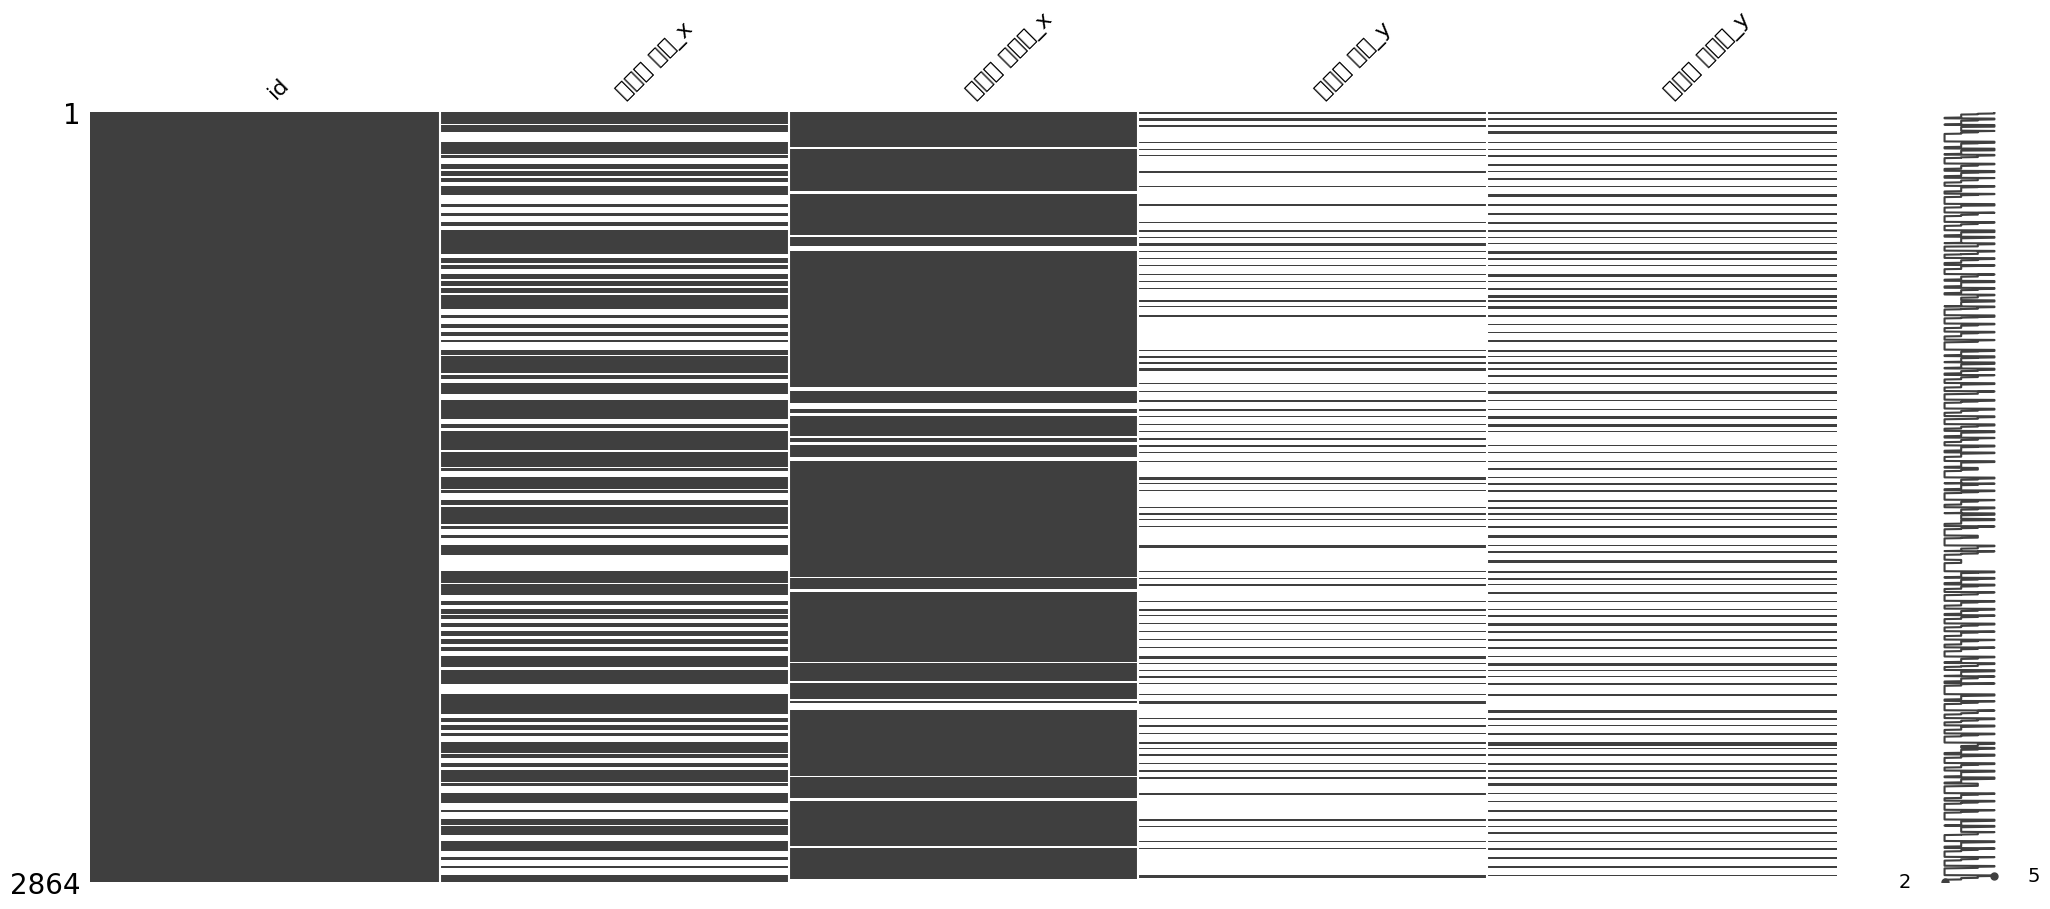

In [ ]:
# 결측치 여부 확인 _ id 누락 부분 확인
msno.matrix(df_id_style) # 결측치 매트릭스 시각화
print(df_id_style.isnull().sum()) # 결측치 합계 확인

In [ ]:
# 스타일 선호 정보표 예시 : ID가 64747인 응답자
df_id_style[df_id_style['id']==64561]

,id,스타일 선호_x,스타일 비선호_x,스타일 선호_y,스타일 비선호_y
0,64561.0,W_18066_50_classic_W.jpg,W_08584_50_feminine_W.jpg,W_18205_50_feminine_W.jpg,W_23519_60_minimal_W.jpg
1,64561.0,W_18205_50_feminine_W.jpg,W_12032_50_feminine_W.jpg,W_22239_60_space_W.jpg,W_48457_60_minimal_W.jpg
2,64561.0,W_18759_50_feminine_W.jpg,W_13444_50_classic_W.jpg,W_33305_60_space_W.jpg,W_33240_80_bodyconscious_W.jpg
3,64561.0,W_22239_60_space_W.jpg,W_23519_60_minimal_W.jpg,W_30671_70_hippie_W.jpg,W_22943_10_athleisure_W.jpg
4,64561.0,W_34974_60_minimal_W.jpg,W_33622_60_minimal_W.jpg,W_35091_80_powersuit_W.jpg,NaN
5,64561.0,W_30671_70_hippie_W.jpg,W_02232_70_hippie_W.jpg,W_06046_10_sportivecasual_W.jpg,NaN
6,64561.0,W_42314_70_hippie_W.jpg,W_32939_70_military_W.jpg,W_38656_10_sportivecasual_W.jpg,NaN
7,64561.0,W_34340_80_bodyconscious_W.jpg,W_46417_70_military_W.jpg,W_41448_10_sportivecasual_W.jpg,NaN
8,64561.0,W_35091_80_powersuit_W.jpg,W_49287_70_punk_W.jpg,NaN,NaN
9,64561.0,W_43737_80_powersuit_W.jpg,W_20944_80_powersuit_W.jpg,NaN,NaN
